## calc de gradient vector for a cavity

In [1]:
using DataFrames
using Chemfiles
using Gadfly
using Cairo
using Distributions
using Bio
using MIToS.PDB
set_default_plot_size(28cm, 10cm)

In [2]:
function tognm(vtor_anm)
    vtor_gnm = Array{Float64}(convert(Int64, length(vtor_anm)/3));
    vtor_anm =  vtor_anm.^2
    for i=1:convert(Int64, length(vtor_anm)/3)
        vtor_gnm[i] = sqrt(vtor_anm[i*3-2] + vtor_anm[i*3-1] + vtor_anm[i*3])
    end
    return vtor_gnm
end

tognm (generic function with 1 method)

In [3]:
function read_ptraj_modes(file, modes_elements)    
    modes_file=open(file, "r")
    modes_text = readdlm(modes_file, skipstart=0, skipblanks=true, 
    ignore_invalid_chars=true, comments=true, comment_char='\*')
    close(modes_file)

    nmodes = modes_text[1, 5]
    ncoords = convert(Int64, modes_elements)
    lines = ceil(Int64, ncoords/7)
    rest = convert(Int64, ncoords % 7)
    
    eval=Array{Float64}(nmodes);
    mode = Array{Float64}(ncoords, nmodes);
    temp1=Array{Float64}(ncoords, 1);
    temp2 = Array{Float64}(ncoords+(7-rest));

    j=lines + 1 + 2 # 1 p/ q lea la prox linea 2 por el header

    for i=1:nmodes
        eval[i] = modes_text[j, 2]
        temp = transpose(modes_text[(j+1):(lines+j), :])
        temp2 = reshape(temp, ncoords+(7-rest))
        for k=(rest+1):7
            pop!(temp2)
        end
    mode[:, i] = temp2
        j = j + lines + 1
    end
    
    for i=1:nmodes
        mode[: ,i] = mode[:, i] / norm(mode[:, i])
    end
    
    return mode, eval
end

read_ptraj_modes (generic function with 1 method)

In [4]:
function displaceAA(mod_pdb, vector1, multiplier)
  # Preparo variables
   pdb = copy(mod_pdb)
   struct_xyz = coordinatesmatrix(pdb)
   new_struct_xyz = copy(struct_xyz)
   natom = Array{Int64}(1)
    vector = Array{Float64}(1, 3)
   aa = length(pdb)
   # Determino el nro de atomos de c/ aminoácido
   for i=1:aa
       push!(natom, length(pdb[i]))
   end  
   shift!(natom)
   temp1 = Array{Int64}(natom[1],3)

   # Adapto el vector p/ darle la misma forma q la matriz de coordenadas
    for i=1:3:length(vector1)
        if i== 1
            vector = reshape(vector1[i:i+2], 1, 3)
            continue
        end
        vector = vcat(vector, reshape(vector1[i:i+2], 1, 3))
    end

   for i=1:aa
       if i == 1         
           temp1 = repmat(vector[i, :], natom[i], 1)
           continue
       end  
       temp2 = repmat(vector[i, :], natom[i], 1)
       temp1 = vcat(temp1, temp2)
   end  
   sum_mat = temp1

   # Listo, ahora puedo mover el pdb
   new_struct_xyz  = struct_xyz + sum_mat .* multiplier
   pdb = change_coordinates(pdb, new_struct_xyz);
   return pdb
end

displaceAA (generic function with 1 method)

## along mode vector coordinates

In [5]:
# Preparo variables
natom_res = Array{Int64}(1);
# Leo el pdb
mto_pdb = read("/home/german/labo/16/hemo/cavities/2displ/bu/mto.pdb", PDBFile, group="ATOM");
# Obtengo el número de átomos de c/ residuo
for i=1:length(mto_pdb)#size(modes_mto)[2]
    push!(natom_res, length(mto_pdb[i]))
end
shift!(natom_res)
# Obtengo el nro de aa's
aa = length(mto_pdb)
aa3 = aa * 3
modo_sum = Array{Float64}(aa, 3);

# indices de Calphas incluidos en el PCA
range_mto = collect(6:125)
range_mto_3 = map(x -> x*3, repeat(range_mto, inner=[3])) - repeat([2, 1, 0], outer = [length(range_mto)]);
# indices de atomos correspondientes a los Calphas incluidos en el PCA
range_atom_mto = collect(127:2063)
range_atom_mto_3 = map(x -> x*3, repeat(range_atom_mto, inner=[3])) - repeat([2, 1, 0], outer = [length(range_atom_mto)]);
# indices de atomos descartados
#head_atom_mto = collect(1:126)
#tail_atom_mto = collect(2064:2128)
#head_atom_mto_3 = map(x -> x*3, repeat(head_atom_mto, inner=[3])) - repeat([2, 1, 0], outer = [length(head_atom_mto)]);
#tail_atom_mto_3 = map(x -> x*3, repeat(tail_atom_mto, inner=[3])) - repeat([2, 1, 0], outer = [length(tail_atom_mto)]);
# Arrays p/ guardar volumenes de pockets
vol_pocket_mto_1 = Array{Float64}(aa3-6);
vol_pocket_mto_2 = Array{Float64}(aa3-6);
vol_pocket_mto_3 = Array{Float64}(aa3-6);

# Leo los modos de PCA. Ya tienen cortados a los aminoácidos de los extremos.
modes_mto, evals_mto = read_ptraj_modes("/home/german/labo/16/hemo/run/mto/pca/modes_mto", aa3);

# Me quedo con los residuos q me importan. Van del 6 al 125, pero en 'natom_res' no están incluidos los caps
# ni el hemo, por eso cambian los indices
#natom_res_full = natom_res
#natom_res = natom_res[4:123];

# Voy a usar esto p/ poner la matriz a sumar en el mismo formato q las coordenadas
#head_mto = repmat([0.0 0.0 0.0], natom_res_full[1]+natom_res_full[2]+natom_res_full[3], 1)
#tail_mto = repmat([0.0 0.0 0.0], natom_res_full[124]+natom_res_full[125]+natom_res_full[126]+natom_res_full[127], 1)

# Template p/ pdbs de salida
files_template = "/home/german/labo/16/hemo/cavities/2displ/mto/"
conf_mto = "/home/german/labo/16/hemo/cavities/2displ/bu/conf_mto.cfg"

"/home/german/labo/16/hemo/cavities/2displ/bu/conf_mto.cfg"

In [6]:
constant = 1
# Ahora tengo q mover la estructura a lo largo de los modos normales, pero esto requiere rearreglar 
# los modos p/ q tengan el mismo formato q las coordenadas de los atomos
for magnitude in [1 3 5 8]
    displacement = string("d", magnitude)
    temp1_modo_sum = Array{Float64}(natom_res[1], 3)
    for j=1:aa3-6
        for i=1:aa
            modo_sum[i, 1] = modes_mto[i*3-2, j]
            modo_sum[i, 2] = modes_mto[i*3-1, j]
            modo_sum[i, 3] = modes_mto[i*3, j]
        end
# Ya tengo el modo en el formato adecuado, pero estos son p/ mover Calphas. Ahora tengo q 
# repetir sus filas p/ poder mover todos los atomos de c/ aminoacido.
        for i=1:aa
            if i == 1            
                temp1_modo_sum = repmat(modo_sum[i, :], natom_res[i], 1)
                continue
            end
            temp2_modo_sum = repmat(modo_sum[i, :], natom_res[i], 1)
            temp1_modo_sum = vcat(temp1_modo_sum, temp2_modo_sum)
        end
modo_sum = copy(temp1_modo_sum)
# Ajusto el desplazamiento q voy a hacer
        factor = magnitude * constant #* (1 / evals_mto[j])
# Modifico las coordenadas
        mto_atom_xyz = coordinatesmatrix(mto_pdb)
        new_mto_atom_xyz = mto_atom_xyz + modo_sum .* factor;
# Obtengo un nuevo frame con las coordenadas modificadas
        new_mto_pdb = change_coordinates(mto_pdb, new_mto_atom_xyz)
# Escribo el nuevo .pdb
        pdb_mto = string(files_template, displacement, "/", "mod", j, "_", displacement, "_mto.pdb")
        write(pdb_mto, new_mto_pdb, PDBFile)
    end
end

In [7]:
# Ahora calculo los vectores
magnitude = 5
displacement = string("d", magnitude)
for j=1:aa3-6
    pdb_mto = string(files_template, displacement, "/", "mod", j, "_", displacement, "_mto.pdb")
# Calculo el pocket    
    vol_mto = string(files_template, displacement, "/vol_mto")
    run(`epock -s $pdb_mto -c $conf_mto -o $vol_mto`)
    rtdo = readdlm(vol_mto)
    vol_pocket_mto_1[j] = rtdo[2, 2]
    vol_pocket_mto_2[j] = rtdo[2, 3]
    vol_pocket_mto_3[j] = rtdo[2, 4]
end 

# Calculo el pocket original
pdb_mto = "/home/german/labo/16/hemo/cavities/2displ/bu/mto.pdb"
vol_mto = "/home/german/labo/16/hemo/cavities/2displ/mto/vol.dat"
run(`epock -s $pdb_mto -c $conf_mto -o $vol_mto`)
rtdo = readdlm(vol_mto)
orig_vol_pocket_mto_1 = rtdo[2, 2]
orig_vol_pocket_mto_2 = rtdo[2, 3]
orig_vol_pocket_mto_3 = rtdo[2, 4]

# Obtengo los vectores gradiente p/ c/ hueco # 1=corto; 2=portal; 3=largo
vec_pocket_mto_1 = (vol_pocket_mto_1 .- orig_vol_pocket_mto_1).^2
vec_pocket_mto_2 = (vol_pocket_mto_2 .- orig_vol_pocket_mto_2).^2
vec_pocket_mto_3 = (vol_pocket_mto_3 .- orig_vol_pocket_mto_3).^2;
# Los normalizo
vec_pocket_mto_1 = vec_pocket_mto_1 / norm(vec_pocket_mto_1)
vec_pocket_mto_2 = vec_pocket_mto_2 / norm(vec_pocket_mto_2)
vec_pocket_mto_3 = vec_pocket_mto_3 / norm(vec_pocket_mto_3)

# Los guardo
out_vec_1 = string("/home/german/labo/16/hemo/cavities/2displ/vtores/", magnitude,"_vec_pocket_mto_corto")
out_vec_2 = string("/home/german/labo/16/hemo/cavities/2displ/vtores/", magnitude,"_vec_pocket_mto_portal")
out_vec_3 = string("/home/german/labo/16/hemo/cavities/2displ/vtores/", magnitude,"_vec_pocket_mto_largo")
df_vec_pocket_mto_1 = DataFrame(delta = vec_pocket_mto_1)
df_vec_pocket_mto_2 = DataFrame(delta = vec_pocket_mto_2)
df_vec_pocket_mto_3 = DataFrame(delta = vec_pocket_mto_3)
writetable(out_vec_1, df_vec_pocket_mto_1)
writetable(out_vec_2, df_vec_pocket_mto_2)
writetable(out_vec_3, df_vec_pocket_mto_3);

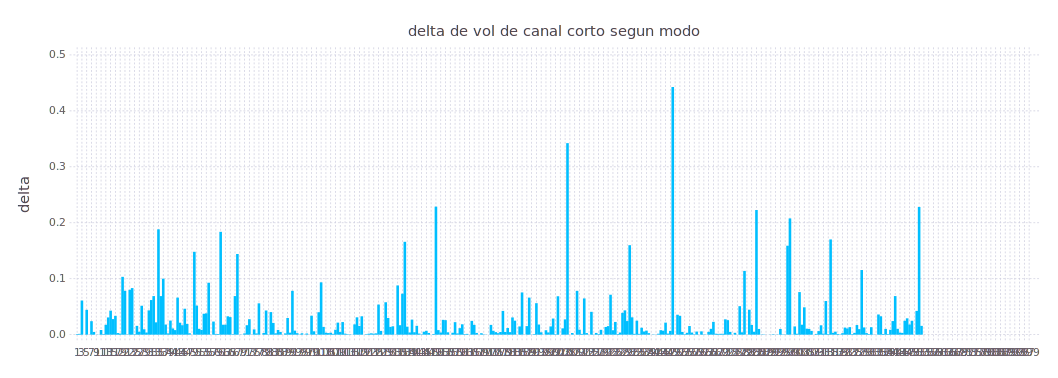

In [8]:
plot(df_vec_pocket_mto_1,
y="delta",  
Geom.bar(position=:dodge), 
Guide.Title("delta de vol de canal corto segun modo"),
Coord.Cartesian(xmin=1, xmax=400),
Guide.xticks(ticks = collect(1:2:400), orientation=:horizontal))

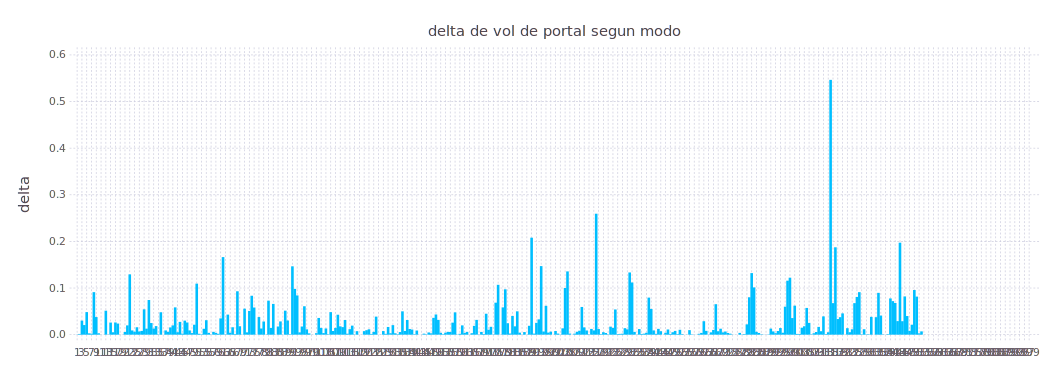

In [9]:
plot(df_vec_pocket_mto_2,
y="delta",  
Geom.bar(position=:dodge), 
Guide.Title("delta de vol de portal segun modo"),
Coord.Cartesian(xmin=1, xmax=400),
Guide.xticks(ticks = collect(1:2:400), orientation=:horizontal))

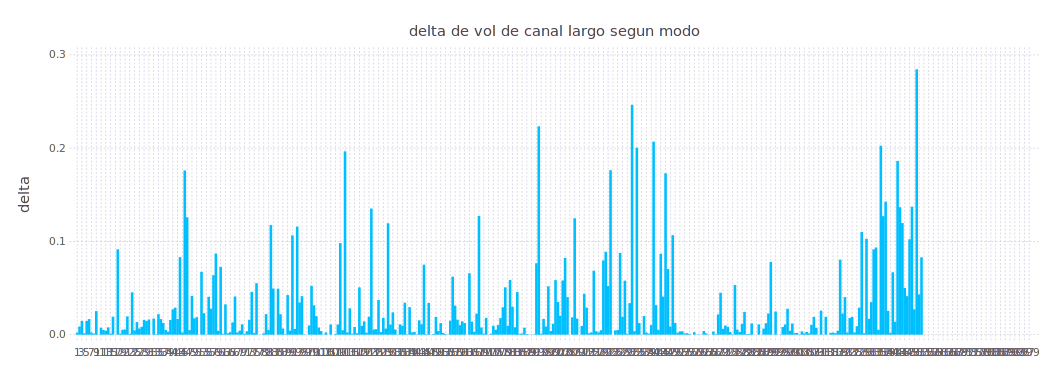

In [10]:
plot(df_vec_pocket_mto_3,
y="delta",  
Geom.bar(position=:dodge), 
Guide.Title("delta de vol de canal largo segun modo"),
Coord.Cartesian(xmin=1, xmax=400),
Guide.xticks(ticks = collect(1:2:400), orientation=:horizontal))

## along cartesian coordinates

In [11]:
# Leo el pdb
pdb_file_original = "/home/german/labo/16/hemo/cavities/3displ/bu/mto.pdb"
pdb = read("/home/german/labo/16/hemo/cavities/3displ/bu/mto.pdb", PDBFile, group="ATOM");
atom_xyz = coordinatesmatrix(pdb)
pdb_name = "mto"
# Obtengo el número de átomos de c/ residuo
natom_res = Array{Int64}(1);
for i=1:length(pdb)
    push!(natom_res, length(pdb[i]))
end
shift!(natom_res)

# Preparo más variables
aa = length(pdb)
aa3 = length(pdb) * 3
#aa_index = collect(3:129)
aa_index = collect(1:120)
aa3_index = map(x -> x*3, repeat(aa_index, inner=[3])) - repeat([2, 1, 0], outer = [length(aa_index)]);
aa_modes = 125 - 6 + 1
aa3_modes = aa_modes * 3 # esta es la long de los modos y el nro de modos + 6
aa_modes_index = collect(6:125)
aa3_modes_index = map(x -> x*3, repeat(aa_modes_index, inner=[3])) - repeat([2, 1, 0], outer = [length(aa_modes_index)]);
modo_sum = Array{Float64}(aa3_modes, 3);
# Arrays p/ guardar volumenes de pockets
vol_pocket_1 = Array{Float64}(aa3);
vol_pocket_2 = Array{Float64}(aa3);
vol_pocket_3 = Array{Float64}(aa3);
# Files de IN / OUT
# IN
files_template = "/home/german/labo/16/hemo/cavities/3displ/mto/"
conf_file = string("/home/german/labo/16/hemo/cavities/3displ/bu/conf_", pdb_name, ".cfg")
#OUT
vol_file = string("/home/german/labo/16/hemo/cavities/3displ/", pdb_name, "vol_", pdb_name)

# Leo los modos de PCA. Ya tienen cortados a los aminoácidos de los extremos.
modes, evals = read_ptraj_modes("/home/german/labo/16/hemo/run/mto/pca/modes_mto", aa3_modes);

In [33]:
# Hago los .pdbs desplazados
constant = 0.01
for magnitude in [1 3 5 8]
    displacement = string("d", magnitude)    
    for j=1:aa
# Preparo p/ desplazar la estructura
        new_atom_xyz = copy(atom_xyz)
        new_pdb = copy(pdb)
        x_add = [repeat([1], inner=[natom_res[j]]) repeat([0], inner=[natom_res[j]]) repeat([0], inner=[natom_res[j]])]
        y_add = [repeat([0], inner=[natom_res[j]]) repeat([1], inner=[natom_res[j]]) repeat([0], inner=[natom_res[j]])]
        z_add = [repeat([0], inner=[natom_res[j]]) repeat([0], inner=[natom_res[j]]) repeat([1], inner=[natom_res[j]])]

# Desplazo en X
        displaced_atom_xyz = coordinatesmatrix(pdb[j]) + x_add .* magnitude .* constant
        new_pdb[j] = change_coordinates(pdb[j], displaced_atom_xyz)        
# Escribo el nuevo .pdb
        pdb_file = string(files_template, displacement, "/", "x", j, "_", displacement, "_", pdb_name,".pdb")
        write(pdb_file, new_pdb, PDBFile)
############
# Desplazo en Y
        displaced_atom_xyz = coordinatesmatrix(pdb[j]) + y_add .* magnitude .* constant
        new_pdb[j] = change_coordinates(pdb[j], displaced_atom_xyz)        
# Escribo el nuevo .pdb
        pdb_file = string(files_template, displacement, "/", "y", j, "_", displacement, "_", pdb_name,".pdb")
        write(pdb_file, new_pdb, PDBFile)
############
# Desplazo en Z
        displaced_atom_xyz = coordinatesmatrix(pdb[j]) + z_add .* magnitude .* constant
        new_pdb[j] = change_coordinates(pdb[j], displaced_atom_xyz)        
# Escribo el nuevo .pdb
        pdb_file = string(files_template, displacement, "/", "z", j, "_", displacement, "_", pdb_name,".pdb")
        write(pdb_file, new_pdb, PDBFile)
    end
end

In [50]:
# Calculo los vectores
magnitude = 8
displacement = string("d", magnitude)    
for j=1:aa    
    pdb_file = string(files_template, displacement, "/", "x", j, "_", displacement, "_", pdb_name,".pdb")
# Calculo los pockets
    run(`epock -s $pdb_file -c $conf_file -o $vol_file`)
    rtdo = readdlm(vol_file)
    vol_pocket_1[j*3-2] = rtdo[2, 2]
    vol_pocket_2[j*3-2] = rtdo[2, 3]
    vol_pocket_3[j*3-2] = rtdo[2, 4]
############
    pdb_file = string(files_template, displacement, "/", "y", j, "_", displacement, "_", pdb_name,".pdb")
# Calculo los pockets
    run(`epock -s $pdb_file -c $conf_file -o $vol_file`)
    rtdo = readdlm(vol_file)
    vol_pocket_1[j*3-1] = rtdo[2, 2]
    vol_pocket_2[j*3-1] = rtdo[2, 3]
    vol_pocket_3[j*3-1] = rtdo[2, 4]
############
    pdb_file = string(files_template, displacement, "/", "z", j, "_", displacement, "_", pdb_name,".pdb")
# Calculo los pockets
    run(`epock -s $pdb_file -c $conf_file -o $vol_file`)
    rtdo = readdlm(vol_file)
    vol_pocket_1[j*3] = rtdo[2, 2]
    vol_pocket_2[j*3] = rtdo[2, 3]
    vol_pocket_3[j*3] = rtdo[2, 4]    
end

# Calculo el pocket original
run(`epock -s $pdb_file_original -c $conf_file -o $vol_file`)
rtdo = readdlm(vol_file)
orig_vol_pocket_1 = rtdo[2, 2]
orig_vol_pocket_2 = rtdo[2, 3]
orig_vol_pocket_3 = rtdo[2, 4]

# Obtengo los vectores gradiente p/ c/ hueco # 1=corto; 2=portal; 3=largo
vec_pocket_1 = (vol_pocket_1 .- orig_vol_pocket_1).^2
vec_pocket_2 = (vol_pocket_2 .- orig_vol_pocket_2).^2
vec_pocket_3 = (vol_pocket_3 .- orig_vol_pocket_3).^2;
# Los normalizo
vec_pocket_1 = vec_pocket_1 / norm(vec_pocket_1)
vec_pocket_2 = vec_pocket_2 / norm(vec_pocket_2)
vec_pocket_3 = vec_pocket_3 / norm(vec_pocket_3)

# Los guardo
out_vec_1 = string("/home/german/labo/16/hemo/cavities/3displ/vtores/", magnitude,"_vec_pocket_mto_corto")
out_vec_2 = string("/home/german/labo/16/hemo/cavities/3displ/vtores/", magnitude,"_vec_pocket_mto_portal")
out_vec_3 = string("/home/german/labo/16/hemo/cavities/3displ/vtores/", magnitude,"_vec_pocket_mto_largo")
df_vec_pocket_1 = DataFrame(delta = vec_pocket_1)
df_vec_pocket_2 = DataFrame(delta = vec_pocket_2)
df_vec_pocket_3 = DataFrame(delta = vec_pocket_3)
writetable(out_vec_1, df_vec_pocket_1)
writetable(out_vec_2, df_vec_pocket_2)
writetable(out_vec_3, df_vec_pocket_3);

# Ahora quiero saber q aa's afectaron al cambio de volumen del hueco.
wall_resi_pocket_1 = convert(Array{Int64}, unique(ceil(aa3_index[vec_pocket_1 .!= 0] ./ 3)))
wall_resi_pocket_2 = convert(Array{Int64}, unique(ceil(aa3_index[vec_pocket_2 .!= 0] ./ 3)))
wall_resi_pocket_3 = convert(Array{Int64}, unique(ceil(aa3_index[vec_pocket_3 .!= 0] ./ 3)));

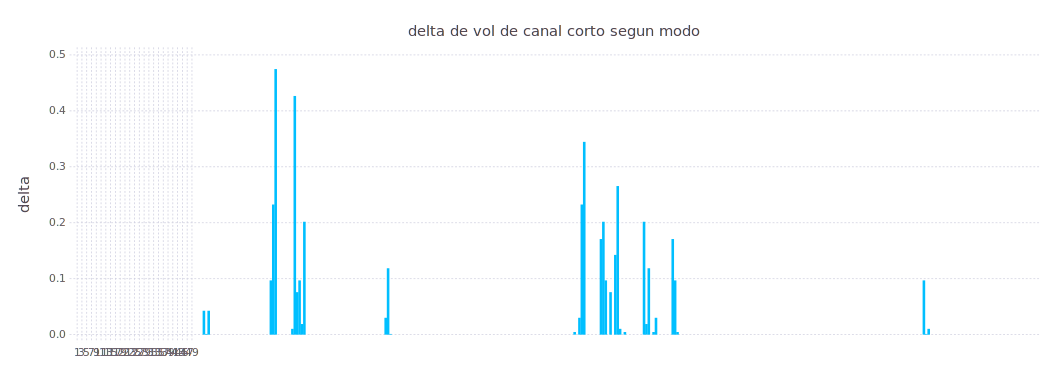

In [51]:
plot(df_vec_pocket_1,
y="delta",  
Geom.bar(position=:dodge), 
Guide.Title("delta de vol de canal corto segun modo"),
Coord.Cartesian(xmin=1, xmax=400),
Guide.xticks(ticks = collect(1:2:50), orientation=:horizontal))

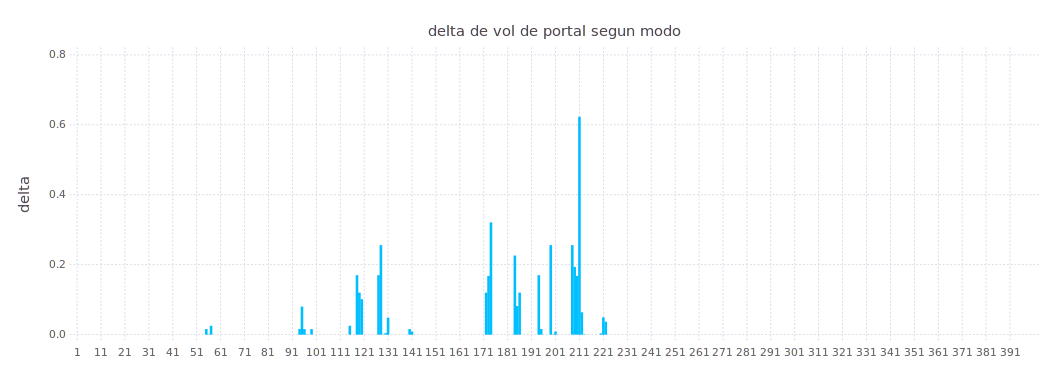

In [52]:
plot(df_vec_pocket_2,
y="delta",  
Geom.bar(position=:dodge), 
Guide.Title("delta de vol de portal segun modo"),
Coord.Cartesian(xmin=1, xmax=400),
Guide.xticks(ticks = collect(1:10:400), orientation=:horizontal))

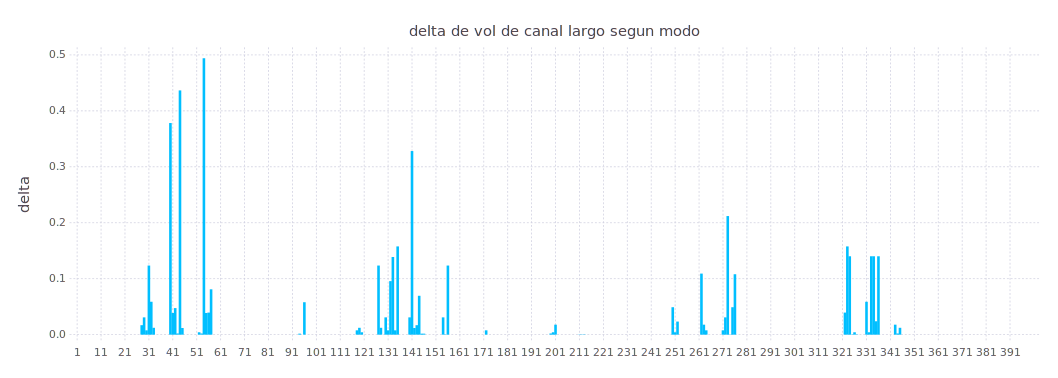

In [53]:
plot(df_vec_pocket_3,
y="delta",  
Geom.bar(position=:dodge), 
Guide.Title("delta de vol de canal largo segun modo"),
Coord.Cartesian(xmin=1, xmax=400),
Guide.xticks(ticks = collect(1:10:400), orientation=:horizontal))

## Ahora miro los modos importantes, según el gradiente en coords de modos

In [ ]:
# corto: modo 3
# portal: modo 4
# largo: modo 1, 4
gnm_1 = tognm(modes[:, 1])
gnm_3 = tognm(modes[:, 3])
gnm_4 = tognm(modes[:, 4]);

df_vec_pocket_gnm_1 = DataFrame(modo = gnm_3)
plot(df_vec_pocket_gnm_1,
y="modo",  
Geom.bar(position=:dodge), 
Guide.Title("fluctuaciones de c/ aminoácido según modo 3"),
Coord.Cartesian(xmin=1, xmax=125),
Guide.xticks(ticks = wall_resi_pocket_1, orientation=:horizontal))

In [ ]:
df_vec_pocket_gnm_1 = DataFrame(modo = gnm_4)
plot(df_vec_pocket_gnm_1,
y="modo",  
Geom.bar(position=:dodge), 
Guide.Title("fluctuaciones de c/ aminoácido según modo 4"),
Coord.Cartesian(xmin=1, xmax=125),
Guide.xticks(ticks = wall_resi_pocket_2, orientation=:horizontal))

In [ ]:
df_vec_pocket_gnm_1 = DataFrame(modo = (gnm_1 + gnm_4))
plot(df_vec_pocket_gnm_1,
y="modo",  
Geom.bar(position=:dodge), 
Guide.Title("fluctuaciones de c/ aminoácido según suma de modos 1 y 4"),
Coord.Cartesian(xmin=1, xmax=125),
Guide.xticks(ticks = wall_resi_pocket_3, orientation=:horizontal))

## Ahora checkeo q den lo mismo

In [32]:
# Checkeo si los vectores gradiente obtenidos con los distintos métodos son similares. 
# Obtengo los gradiente en base de modos a partir de los gradiente en cartesianas.
from_xyz_vec_pocket_1 = transpose(modes) * vec_pocket_1
from_xyz_vec_pocket_1 = from_xyz_vec_pocket_1 / norm(from_xyz_vec_pocket_1)
#
from_xyz_vec_pocket_2 = transpose(modes) * vec_pocket_2
from_xyz_vec_pocket_2 = from_xyz_vec_pocket_2 / norm(from_xyz_vec_pocket_2)
#
from_xyz_vec_pocket_3 = transpose(modes) * vec_pocket_3
from_xyz_vec_pocket_3 = from_xyz_vec_pocket_3 / norm(from_xyz_vec_pocket_3)

# Ahora hago los dot products p/ comparar
#dot(from_xyz_vec_pocket_1, vec_pocket_mto_1)
#dot(from_xyz_vec_pocket_2, vec_pocket_mto_2)
dot(from_xyz_vec_pocket_3, vec_pocket_mto_3)

0.018264268842674077

In [31]:
# Checkeo si los vectores gradiente obtenidos con los distintos métodos son similares. 
# Obtengo los gradiente en base de cartesianas a partir de los gradiente en base de modos.

from_mode_vec_pocket_1 = modes * vec_pocket_mto_1
from_mode_vec_pocket_1 = from_mode_vec_pocket_1 / norm(from_mode_vec_pocket_1)
#
from_mode_vec_pocket_2 = modes * vec_pocket_mto_2
from_mode_vec_pocket_2 = from_mode_vec_pocket_2 / norm(from_mode_vec_pocket_2)
#
from_mode_vec_pocket_3 = modes * vec_pocket_mto_3
from_mode_vec_pocket_3 = from_mode_vec_pocket_3 / norm(from_mode_vec_pocket_3)

# Ahora hago los dot products p/ comparar.
#dot(vec_pocket_1, from_mode_vec_pocket_1)
#dot(vec_pocket_2, from_mode_vec_pocket_2)
dot(vec_pocket_3, from_mode_vec_pocket_3)

0.017614048372920257

In [ ]:
df_1 = DataFrame(modo = from_mode_vec_pocket_1)
plot(df_1,
y="modo",  
Geom.bar(position=:dodge), 
Guide.Title("fluctuaciones de c/ aminoácido según suma de modos 1 y 4"),
Coord.Cartesian(xmin=1, xmax=400),
Guide.xticks(ticks = wall_resi_pocket_3, orientation=:horizontal))

## Ahora meto unos modos artificiales p/ q de igual q en coordenadas cartesianas
## y checkeo q efectivamente de igual

In [ ]:
# Preparo variables
natom_res = Array{Int64}(1);
# Leo el pdb
mto_pdb = read("/home/german/labo/16/hemo/cavities/2displ/bu/mto.pdb", PDBFile, group="ATOM");
# Obtengo el número de átomos de c/ residuo
for i=1:length(mto_pdb)#size(modes_mto)[2]
    push!(natom_res, length(mto_pdb[i]))
end
shift!(natom_res)
# Obtengo el nro de aa's
aa = length(mto_pdb)
aa3 = aa * 3
modo_sum = Array{Float64}(aa, 3);

# indices de Calphas incluidos en el PCA
range_mto = collect(6:125)
range_mto_3 = map(x -> x*3, repeat(range_mto, inner=[3])) - repeat([2, 1, 0], outer = [length(range_mto)]);
# indices de atomos correspondientes a los Calphas incluidos en el PCA
range_atom_mto = collect(127:2063)
range_atom_mto_3 = map(x -> x*3, repeat(range_atom_mto, inner=[3])) - repeat([2, 1, 0], outer = [length(range_atom_mto)]);
# indices de atomos descartados
#head_atom_mto = collect(1:126)
#tail_atom_mto = collect(2064:2128)
#head_atom_mto_3 = map(x -> x*3, repeat(head_atom_mto, inner=[3])) - repeat([2, 1, 0], outer = [length(head_atom_mto)]);
#tail_atom_mto_3 = map(x -> x*3, repeat(tail_atom_mto, inner=[3])) - repeat([2, 1, 0], outer = [length(tail_atom_mto)]);
# Arrays p/ guardar volumenes de pockets
vol_pocket_mto_1 = Array{Float64}(aa3);
vol_pocket_mto_2 = Array{Float64}(aa3);
vol_pocket_mto_3 = Array{Float64}(aa3);

# Leo los modos de PCA. Ya tienen cortados a los aminoácidos de los extremos.
#modes_mto, evals_mto = read_ptraj_modes("/home/german/labo/16/hemo/run/mto/pca/modes_mto", aa3);
modes_mto = diagm(repeat([1], inner=[360]))
evals_mto = repeat([1], inner=[360])
# Me quedo con los residuos q me importan. Van del 6 al 125, pero en 'natom_res' no están incluidos los caps
# ni el hemo, por eso cambian los indices
#natom_res_full = natom_res
#natom_res = natom_res[4:123];

# Voy a usar esto p/ poner la matriz a sumar en el mismo formato q las coordenadas
#head_mto = repmat([0.0 0.0 0.0], natom_res_full[1]+natom_res_full[2]+natom_res_full[3], 1)
#tail_mto = repmat([0.0 0.0 0.0], natom_res_full[124]+natom_res_full[125]+natom_res_full[126]+natom_res_full[127], 1)

# Template p/ pdbs de salida
files_template = "/home/german/labo/16/hemo/cavities/2displ/mto/"

In [ ]:
constant = 0.1
# Ahora tengo q mover la estructura a lo largo de los modos normales, pero esto requiere rearreglar 
# los modos p/ q tengan el mismo formato q las coordenadas de los atomos
for magnitude in [1 3 5 8]
    displacement = string("d", magnitude)
    temp1_modo_sum = Array{Float64}(natom_res[1], 3)
    for j=1:aa3
        for i=1:aa
            modo_sum[i, 1] = modes_mto[i*3-2, j]
            modo_sum[i, 2] = modes_mto[i*3-1, j]
            modo_sum[i, 3] = modes_mto[i*3, j]
        end
# Ya tengo el modo en el formato adecuado, pero estos son p/ mover Calphas. Ahora tengo q 
# repetir sus filas p/ poder mover todos los atomos de c/ aminoacido.
        for i=1:aa
            if i == 1            
                temp1_modo_sum = repmat(modo_sum[i, :], natom_res[i], 1)
                continue
            end
            temp2_modo_sum = repmat(modo_sum[i, :], natom_res[i], 1)
            temp1_modo_sum = vcat(temp1_modo_sum, temp2_modo_sum)
        end
modo_sum = copy(temp1_modo_sum)
# Ajusto el desplazamiento q voy a hacer
        factor = magnitude * constant * (1 / evals_mto[j])
# Modifico las coordenadas
        mto_atom_xyz = coordinatesmatrix(mto_pdb)
        new_mto_atom_xyz = mto_atom_xyz + modo_sum .* factor;
# Obtengo un nuevo frame con las coordenadas modificadas
        new_mto_pdb = change_coordinates(mto_pdb, new_mto_atom_xyz)
# Escribo el nuevo .pdb
        pdb_mto = string(files_template, displacement, "/", "mod", j, "_", displacement, "_mto.pdb")
        write(pdb_mto, new_mto_pdb, PDBFile)
    end
end

In [ ]:
# Ahora calculo los vectores
magnitude = 8
displacement = string("d", magnitude)
for j=1:aa3
    pdb_mto = string(files_template, displacement, "/", "mod", j, "_", displacement, "_mto.pdb")
# Calculo el pocket
    conf_mto = string(files_template, displacement, "/conf_mto.cfg")
    vol_mto = string(files_template, displacement, "/vol_mto")
    run(`epock -s $pdb_mto -c $conf_mto -o $vol_mto`)
    rtdo = readdlm(vol_mto)
    vol_pocket_mto_1[j] = rtdo[2, 2]
    vol_pocket_mto_2[j] = rtdo[2, 3]
    vol_pocket_mto_3[j] = rtdo[2, 4]
end 

# Calculo el pocket original
pdb_mto = "/home/german/labo/16/hemo/cavities/2displ/bu/mto.pdb"
conf_mto = "/home/german/labo/16/hemo/cavities/2displ/mto/d1/conf_mto"
vol_mto = "/home/german/labo/16/hemo/cavities/2displ/mto/vol.dat"
run(`epock -s $pdb_mto -c $conf_mto -o $vol_mto`)
rtdo = readdlm(vol_mto)
orig_vol_pocket_mto_1 = rtdo[2, 2]
orig_vol_pocket_mto_2 = rtdo[2, 3]
orig_vol_pocket_mto_3 = rtdo[2, 4]

# Obtengo los vectores gradiente p/ c/ hueco # 1=corto; 2=portal; 3=largo
vec_pocket_mto_1 = (vol_pocket_mto_1 .- orig_vol_pocket_mto_1).^2
vec_pocket_mto_2 = (vol_pocket_mto_2 .- orig_vol_pocket_mto_2).^2
vec_pocket_mto_3 = (vol_pocket_mto_3 .- orig_vol_pocket_mto_3).^2;
# Los normalizo
vec_pocket_mto_1 = vec_pocket_mto_1 / norm(vec_pocket_mto_1)
vec_pocket_mto_2 = vec_pocket_mto_2 / norm(vec_pocket_mto_2)
vec_pocket_mto_3 = vec_pocket_mto_3 / norm(vec_pocket_mto_3)

# Los guardo
out_vec_1 = string("/home/german/labo/16/hemo/cavities/2displ/vtores/", magnitude,"_vec_pocket_mto_corto")
out_vec_2 = string("/home/german/labo/16/hemo/cavities/2displ/vtores/", magnitude,"_vec_pocket_mto_portal")
out_vec_3 = string("/home/german/labo/16/hemo/cavities/2displ/vtores/", magnitude,"_vec_pocket_mto_largo")
writedlm(out_vec_1, vec_pocket_mto_1)
writedlm(out_vec_2, vec_pocket_mto_2)
writedlm(out_vec_3, vec_pocket_mto_3);

In [ ]:
df_vec_pocket_mto_1 = DataFrame(delta = vec_pocket_mto_1)
plot(df_vec_pocket_mto_1,
y="delta",  
Geom.bar(position=:dodge), 
Guide.Title("delta de vol de canal corto segun modo"),
Coord.Cartesian(xmin=1, xmax=400),
Guide.xticks(ticks = collect(1:10:400), orientation=:horizontal))

In [ ]:
df_vec_pocket_mto_2 = DataFrame(delta = vec_pocket_mto_2)
plot(df_vec_pocket_mto_2,
y="delta",  
Geom.bar(position=:dodge), 
Guide.Title("delta de vol de portal segun modo"),
Coord.Cartesian(xmin=1, xmax=400),
Guide.xticks(ticks = collect(1:10:400), orientation=:horizontal))

In [ ]:
df_vec_pocket_mto_3 = DataFrame(delta = vec_pocket_mto_3)
plot(df_vec_pocket_mto_3,
y="delta",  
Geom.bar(position=:dodge), 
Guide.Title("delta de vol de canal largo segun modo"),
Coord.Cartesian(xmin=1, xmax=400),
Guide.xticks(ticks = collect(1:10:400), orientation=:horizontal))